# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.sklearn.LibSVMWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibSVMWorkflow --monotonic --max-evals 100 -t 1800 --initial-configs configs.csv
```
this will create the `results.csv` file.

In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [2]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,C,cache_size,cap_max_iter,class_weight,coef0,degree,gamma,kernel,max_iter,pp_cat_encoder,pp_decomposition,pp_featuregen,pp_featureselector,pp_scaler,shrinking,tol
0,1.000000e+00,16000.0,False,none,1.000000e-01,2,1.000000e+00,rbf,10000,ordinal,none,none,generic,none,True,0.001000
1,4.556443e-04,16000.0,True,balanced,2.254438e-11,4,8.639195e-07,rbf,2393,ordinal,ka_nystroem,poly2,select75,minmax,True,0.001260
2,1.190127e-04,16000.0,False,none,1.790640e-09,5,7.212491e+08,sigmoid,127,ordinal,none,poly3,select75,minmax,False,1.393452
3,1.168628e-10,16000.0,False,none,4.252553e+07,2,2.333273e-12,rbf,4007,onehot,ka_rbf,none,select90,none,False,0.000211
4,1.421376e+03,16000.0,False,none,2.440596e-08,2,1.030375e+00,rbf,6037,onehot,agglomerator,poly2,none,none,True,0.000186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.694784e-02,16000.0,False,balanced,2.851649e-07,3,1.054283e-09,sigmoid,156,ordinal,none,none,select75,std,False,0.092271
96,9.974934e-03,16000.0,False,balanced,3.618830e+03,2,1.059185e+06,poly,914,ordinal,fastica,poly2,select50,std,False,0.683440
97,5.654174e-11,16000.0,False,balanced,3.804306e+05,5,6.310865e-04,rbf,882,ordinal,none,poly3,generic,std,False,0.098460
98,7.419871e+06,16000.0,False,balanced,3.717721e+06,5,3.623190e-02,poly,1280,ordinal,fastica,none,select90,minmax,False,0.039080


In [3]:
def prepare_df(df):
    """Prepare the dataframe for analysis. For example, load the arrays/list from json format.
    """

    # Convert the string to JSON
    str_to_json = lambda x: x.replace("'", '"').replace("nan", "NaN").replace("inf", "Infinity")
    load_json = lambda x: json.loads(str_to_json(x))
    load_array = lambda x: np.array(load_json(x))

    # Load the arrays
    columns = ["m:fidelity_values", "m:score_types", "m:score_values"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_array)

    # Load the dicts
    columns = ["m:child_fidelities"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_json)

    return df

In [4]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df = pd.read_csv("results.csv")
r_df_failed = r_df[[v == "F" for v in r_df["objective"]]]

r_df = r_df[[v != "F" for v in r_df["objective"]]]
r_df.sort_values("job_id", inplace=True)

r_df = prepare_df(r_df)
r_df

,p:C,p:cap_max_iter,p:class_weight,p:coef0,p:degree,p:gamma,p:kernel,p:max_iter,p:pp_cat_encoder,p:pp_decomposition,...,m:child_fidelities,m:dataset_id,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:workflow_seed,m:traceback
0,1.000000e+00,False,none,1.000000e-01,2,1.000000e+00,rbf,10000,ordinal,none,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
7,4.556443e-04,True,balanced,2.254438e-11,4,8.639195e-07,rbf,2393,ordinal,ka_nystroem,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
42,1.190127e-04,False,none,1.790640e-09,5,7.212491e+08,sigmoid,127,ordinal,none,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
4,1.168628e-10,False,none,4.252553e+07,2,2.333273e-12,rbf,4007,onehot,ka_rbf,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
3,1.421376e+03,False,none,2.440596e-08,2,1.030375e+00,rbf,6037,onehot,agglomerator,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,5.654174e-11,False,balanced,3.804306e+05,5,6.310865e-04,rbf,882,ordinal,none,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
93,2.251791e+10,True,balanced,2.193107e+11,4,4.675972e-04,sigmoid,1290,ordinal,agglomerator,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
94,1.090931e-06,False,balanced,2.024592e-11,3,6.723295e-09,rbf,8484,onehot,pca,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN
99,9.519140e+09,True,none,2.613230e-12,4,4.011946e+06,sigmoid,906,onehot,none,...,[],3,lcdb.workflow.sklearn.LibSVMWorkflow,0.1,0.1,True,42,42,42,NaN


In [5]:
idx = 0
print(r_df_failed.iloc[idx])
print(r_df_failed.iloc[idx]["m:traceback"])

p:C                                                              0.196069
p:cap_max_iter                                                      False
p:class_weight                                                   balanced
p:coef0                                                44200116344.183922
p:degree                                                                4
p:gamma                                                           0.02801
p:kernel                                                             poly
p:max_iter                                                            660
p:pp_cat_encoder                                                   onehot
p:pp_decomposition                                                fastica
p:pp_featuregen                                                     poly2
p:pp_featureselector                                                 none
p:pp_scaler                                                        minmax
p:shrinking                           

In [6]:
sorted(r_df["objective"])

['0.46875',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.47812',
 '0.48125',
 '0.49062',
 '0.50938',
 '0.51875',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.52188',
 '0.54375',
 '0.54688',
 '0.55312',
 '0.55625',
 '0.57188',
 '0.58438',
 '0.59375',
 '0.6',
 '0.60625',
 '0.61562',
 '0.61875',
 '0.61875',
 '0.65312',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66562',
 '0.66875',
 '0.68125',
 '0.68438',
 '0.69375',
 '0.71562',
 '0.73125',
 '0.73438',
 '0.74062',
 '0.82188',
 '0.8312

In [7]:
# Check the columns
r_df.columns.to_list()

['p:C',
 'p:cap_max_iter',
 'p:class_weight',
 'p:coef0',
 'p:degree',
 'p:gamma',
 'p:kernel',
 'p:max_iter',
 'p:pp_cat_encoder',
 'p:pp_decomposition',
 'p:pp_featuregen',
 'p:pp_featureselector',
 'p:pp_scaler',
 'p:shrinking',
 'p:tol',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:child_fidelities',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed',
 'm:workflow_seed',
 'm:traceback']

In [8]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.")

Cumulated time (without submit/gather overheads): 1416.06 s.
Cumulated time (with submit/gather overheads)   : 1449.84 s.
Overheads accounted for 2.39 % of the total time.

Real time of execution: 266.82 s.


In [9]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 15.06 s.
Std  time per job: 24.32 s.


In [10]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


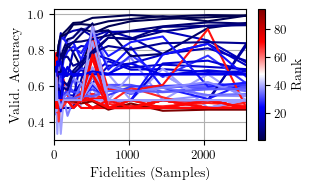

In [11]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure()

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()